In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
cocacola = pd.read_excel("D:\ExcelR\Assigments\Forecasting\CocaCola_Sales_Rawdata.xlsx")
cocacola.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [3]:
cocacola.shape

(42, 2)

In [4]:
cocacola.dtypes

Quarter     object
Sales      float64
dtype: object

In [5]:
cocacola.isna().sum()

Quarter    0
Sales      0
dtype: int64

<AxesSubplot:>

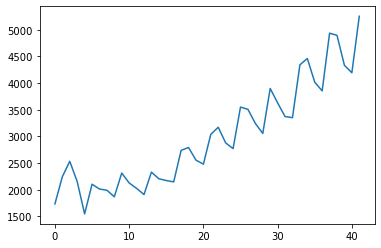

In [6]:
cocacola['Sales'].plot()

<AxesSubplot:xlabel='Sales', ylabel='Density'>

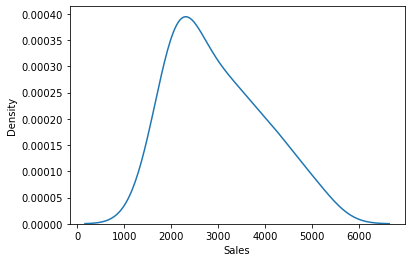

In [7]:
sns.distplot(cocacola['Sales'], hist=False)

In [8]:
cocacola['quart'] = 0
for i in range(42):
    p = cocacola['Quarter'][i]
    cocacola['quart'][i] = p[0:2]

In [9]:
cocacola.head()

,Quarter,Sales,quart
0,Q1_86,1734.827000,Q1
1,Q2_86,2244.960999,Q2
2,Q3_86,2533.804993,Q3
3,Q4_86,2154.962997,Q4
4,Q1_87,1547.818996,Q1


In [10]:
dummies  = pd.DataFrame(pd.get_dummies(cocacola['quart']))

In [11]:
cola = pd.concat([cocacola,dummies],axis=1)

In [12]:
cola.head()

,Quarter,Sales,quart,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1,1,0,0,0


In [13]:
cola['t'] = np.arange(0,42)
cola['t_sqr'] = cola['t']*cola['t']
cola['log_sales'] = np.log(cola['Sales'])
cola.head()

,Quarter,Sales,quart,Q1,Q2,Q3,Q4,t,t_sqr,log_sales
0,Q1_86,1734.827000,Q1,1,0,0,0,0,0,7.458663
1,Q2_86,2244.960999,Q2,0,1,0,0,1,1,7.716443
2,Q3_86,2533.804993,Q3,0,0,1,0,2,4,7.837477
3,Q4_86,2154.962997,Q4,0,0,0,1,3,9,7.675529
4,Q1_87,1547.818996,Q1,1,0,0,0,4,16,7.344602


<AxesSubplot:xlabel='quart', ylabel='Sales'>

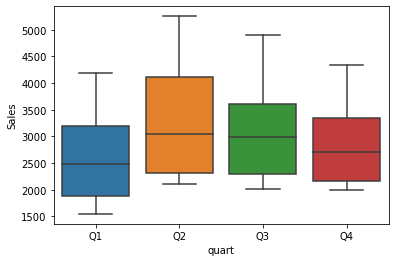

In [14]:
sns.boxplot(x="quart",y="Sales",data=cola)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

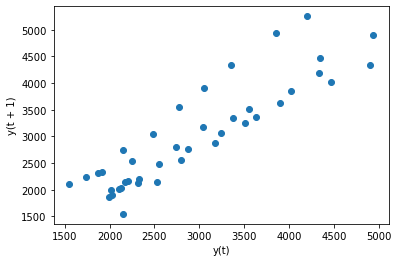

In [15]:
pd.plotting.lag_plot(cola['Sales'])

In [16]:
import statsmodels.graphics.tsaplots as tsa_plots

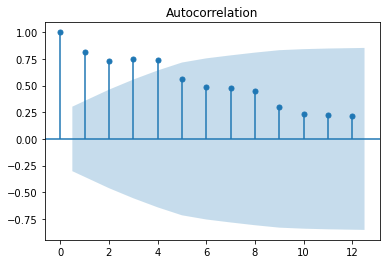

In [17]:
tsa_plots.plot_acf(cola['Sales'],lags=12)
plt.show()

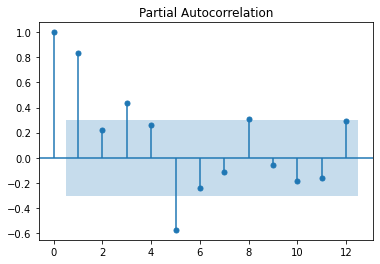

In [18]:
tsa_plots.plot_pacf(cola['Sales'],lags=12)
plt.show()

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

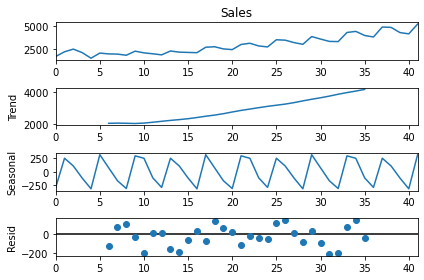

In [20]:
ts_decompose = seasonal_decompose(cola['Sales'],period = 12)
ts_decompose.plot()
plt.show()

In [21]:
cola.shape

(42, 10)

In [64]:
train = cola.head(30)
test = cola.tail(12)

In [65]:
train.tail()

,Quarter,Sales,quart,Q1,Q2,Q3,Q4,t,t_sqr,log_sales
25,Q2_92,3550.000000,Q2,0,1,0,0,25,625,8.174703
26,Q3_92,3508.000000,Q3,0,0,1,0,26,676,8.162801
27,Q4_92,3243.859993,Q4,0,0,0,1,27,729,8.084519
28,Q1_93,3056.000000,Q1,1,0,0,0,28,784,8.024862
29,Q2_93,3899.000000,Q2,0,1,0,0,29,841,8.268475


In [66]:
test.head()

,Quarter,Sales,quart,Q1,Q2,Q3,Q4,t,t_sqr,log_sales
30,Q3_93,3629.0,Q3,0,0,1,0,30,900,8.196712
31,Q4_93,3373.0,Q4,0,0,0,1,31,961,8.123558
32,Q1_94,3352.0,Q1,1,0,0,0,32,1024,8.117312
33,Q2_94,4342.0,Q2,0,1,0,0,33,1089,8.376090
34,Q3_94,4461.0,Q3,0,0,1,0,34,1156,8.403128


# Model based forecasting

In [25]:
import statsmodels.formula.api as smf

### linear model

In [67]:
lnr_model = smf.ols('Sales~t',data = train).fit()
pred_lnr = pd.Series(lnr_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_lnr))**2))
print('RMSE Linear:',rmse_linear)

RMSE Linear: 714.0144483281301


### Exponential model

In [70]:
exp_model = smf.ols('log_sales~t',data = train).fit()
pred_exp = pd.Series(exp_model.predict(pd.DataFrame(test['t'])))
rmse_exponential = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_exp)))**2))
print('RMSE exponential:',rmse_exponential)

RMSE exponential: 552.2821039079295


### Quadratic model

In [71]:
qd_model = smf.ols('Sales~t+t_sqr',data=train).fit()
pred_qd =  pd.Series(qd_model.predict(pd.DataFrame(test[['t','t_sqr']])))
rmse_quadratic = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_qd))**2))
print("RMSE Quadratic: ",rmse_quadratic)

RMSE Quadratic:  646.2715428311569


### Additive seasonality

In [72]:
add_sea_model = smf.ols('Sales~Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea =  pd.Series(add_sea_model.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
rmse_additive_seasonality = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_additive_seasonality)

RMSE Additive seasonality:  1778.006546794136


### Additive seasonality quadratic

In [73]:
add_sea_qd_model = smf.ols('Sales~t+t_sqr+Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea_qd =  pd.Series(add_sea_qd_model.predict(pd.DataFrame(test[['t','t_sqr','Q1','Q2','Q3','Q4']])))
rmse_additive_seasonality_quadratic = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea_qd))**2))
print("RMSE Additive seasonality quadratic: ",rmse_additive_seasonality_quadratic)

RMSE Additive seasonality quadratic:  586.0533067872025


### Multiplicative seasonalty

In [74]:
mult_sea_model = smf.ols('log_sales~Q1+Q2+Q3+Q4',data=train).fit()
pred_mult_sea =  pd.Series(mult_sea_model.predict(test))
rmse_multiplicative_seasonality = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_mult_sea)))**2))
print("RMSE Multiplicative seasonality: ",rmse_multiplicative_seasonality)

RMSE Multiplicative seasonality:  1828.9238912138076


### Multiplicative additive seasonality

In [75]:
mult_add_sea_model = smf.ols('log_sales~t+Q1+Q2+Q3+Q4',data=train).fit()
pred_mult_add_sea =  pd.Series(mult_add_sea_model.predict(test))
rmse_multiplicative_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_mult_add_sea)))**2))
print("RMSE Multiplicative additive seasonality: ",rmse_multiplicative_add_sea)

RMSE Multiplicative additive seasonality:  410.2497059609462


# Data driven forecasting

### Moving average

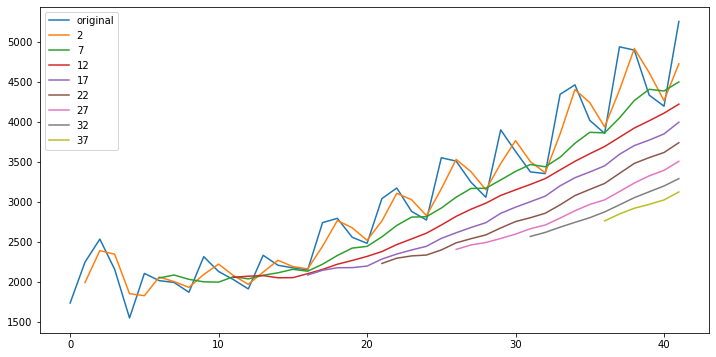

In [82]:
plt.figure(figsize=(12,6))
cola['Sales'].plot(label='original')
for i in range(2,40,5):
    cola['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best') 

### Simple exponential smoothing model

In [34]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,Holt,ExponentialSmoothing

In [77]:
ses_model = SimpleExpSmoothing(train['Sales']).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start=test.index[0],end=test.index[-1])
ses_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_ses))**2))
ses_rmse

1153.703123942556

### Holt model

In [76]:
holt_model = Holt(train['Sales']).fit(smoothing_level=0.8,smoothing_slope=0.2)
pred_holt = holt_model.predict(start=test.index[0],end=test.index[-1])
holt_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_holt))**2))
holt_rmse

559.5201215789893

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [69]:
hwe_model_m_a = ExponentialSmoothing(train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_m_a = hwe_model_m_a.predict(start = test.index[0],end = test.index[-1])

hw_ma_rms=np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_hwe_m_a))**2))
hw_ma_rms

213.5404667455106

### Holts winter exponential smoothing with additive seasonality and multiplicative trend

In [78]:
hwe_model_a_m = ExponentialSmoothing(train["Sales"],seasonal="add",trend="mul",seasonal_periods=12).fit() 
pred_hwe_a_m = hwe_model_a_m.predict(start = test.index[0],end = test.index[-1])

hw_am_rms=np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_hwe_a_m))**2))
hw_am_rms

253.28638375298647

### Holts winter exponential smoothing with additive seasonality and additive trend

In [79]:
hwe_model_a_a = ExponentialSmoothing(train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() 
pred_hwe_a_a = hwe_model_a_a.predict(start = test.index[0],end = test.index[-1])

hw_aa_rms=np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_hwe_a_a))**2))
hw_aa_rms

235.53845888263783

In [40]:
from statsmodels.tsa.arima_model import ARIMA,ARMA

### ARMA model

In [80]:
ARMA_model = ARMA(train['Sales'],order=(3,0)).fit()
pred_arma = ARMA_model.predict(start = test.index[0],end = test.index[-1])

arma_rmse=np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_arma))**2))
arma_rmse

1027.8888300373405

### ARIMA model

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

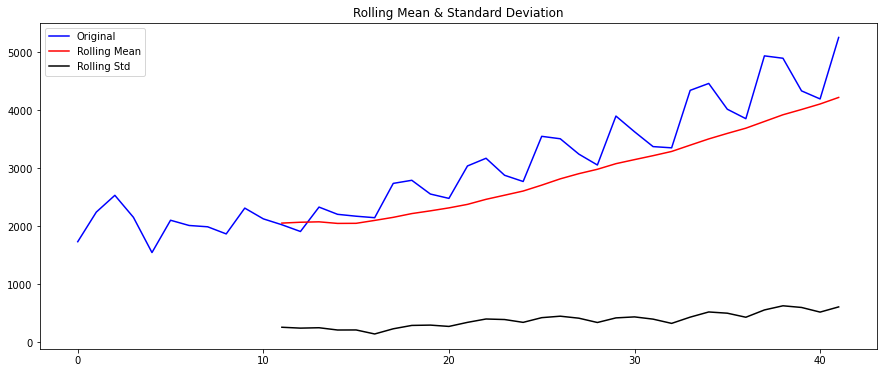

In [81]:
plt.figure(figsize=(15,6))
rollingmean=cola['Sales'].rolling(12).mean()
rollingstd=cola['Sales'].rolling(12).std()
plt.plot(cola['Sales'], color='blue',label='Original')
plt.plot(rollingmean, color='red', label='Rolling Mean')
plt.plot(rollingstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

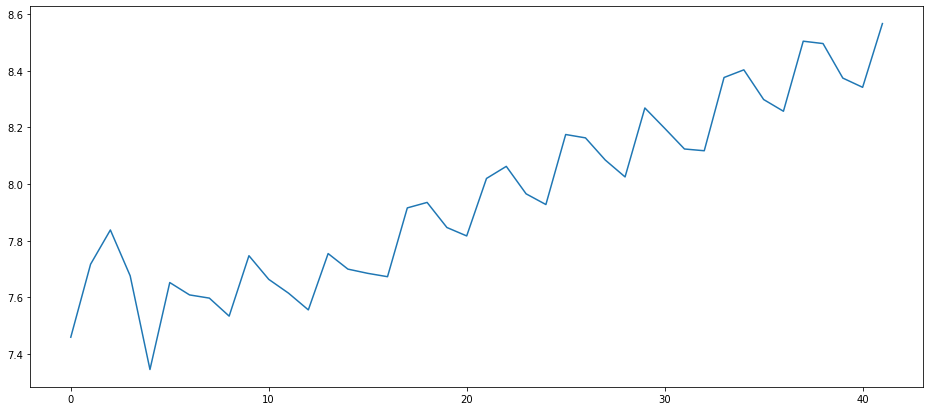

In [83]:
plt.figure(figsize=(16,7))
ts_log = np.log(cola['Sales'])
plt.plot(ts_log)

#### -differencing

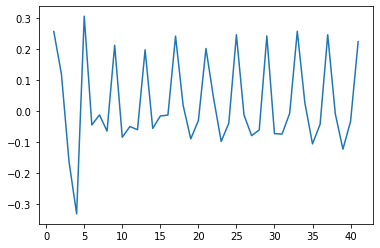

In [84]:
ts_log_diff = ts_log - ts_log.shift(periods=1)
plt.plot(ts_log_diff)

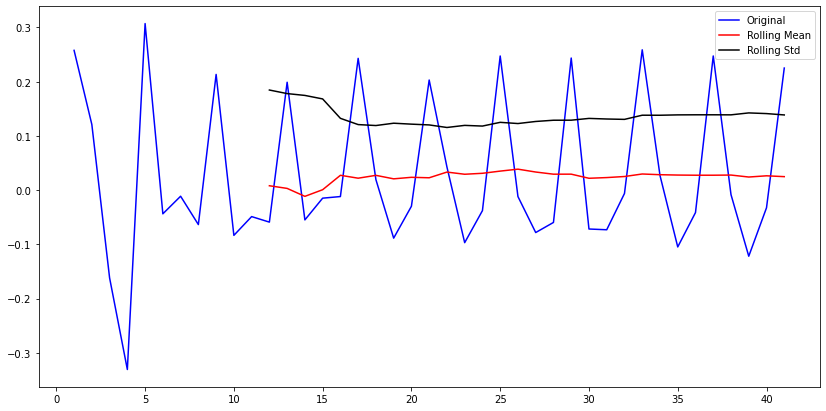

In [85]:
plt.figure(figsize=(14,7))
rollingmean = ts_log_diff.rolling(12).mean()
rollingstd = ts_log_diff.rolling(12).std()
plt.plot(ts_log_diff, color='blue',label='Original')
plt.plot(rollingmean, color='red', label='Rolling Mean')
plt.plot(rollingstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')

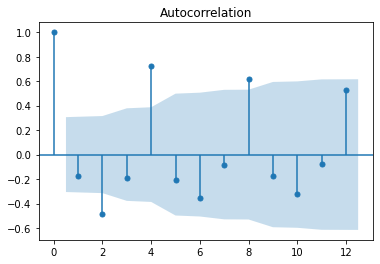

In [86]:
tsa_plots.plot_acf(ts_log_diff.dropna(),lags=12)
plt.show()

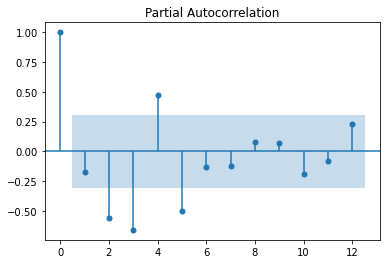

In [87]:
tsa_plots.plot_pacf(ts_log_diff.dropna(),lags=12)
plt.show()

In [88]:
import itertools

In [89]:
p =range(0,5)
d =range(0,5)
q =range(0,5)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [90]:
for params in pdq:
    try:
        arima_model = ARIMA(cola['Sales'],order=params).fit()
        print(params,arima_model.aic)
    except:
        continue

(0, 0, 0) 700.5556163745397
(0, 0, 1) 672.762736956785
(0, 0, 2) 638.008834749387
(0, 0, 3) 636.3109830688481
(0, 0, 4) 633.6839601305363
(0, 1, 0) 617.614937007783
(0, 1, 1) 607.2777519927466
(0, 1, 2) 606.1629102765434
(0, 1, 3) 600.7282513080645
(0, 1, 4) 580.4028970884216
(0, 2, 0) 633.3976676318601
(0, 2, 1) 608.9435813557418
(0, 2, 2) 593.1929075724838
(0, 2, 3) 618.5524422768312
(0, 2, 4) 588.2527507352424
(1, 0, 0) 637.530201123372
(1, 0, 1) 634.7258695324592
(1, 0, 2) 633.8105570855254
(1, 0, 3) 625.3717125511403
(1, 0, 4) 602.167359428431
(1, 1, 0) 618.8473071312175
(1, 1, 1) 608.7365920341316
(1, 1, 2) 607.9196281049088
(1, 1, 4) 582.3541746769844
(1, 2, 0) 632.8484102560508
(1, 2, 1) 610.3765649381041
(2, 0, 0) 639.2219342956333
(2, 0, 1) 636.2035733016971
(2, 0, 2) 635.6406372357883
(2, 0, 3) 622.8063221851376
(2, 0, 4) 604.1116129207412
(2, 1, 0) 597.8209706471662
(2, 1, 1) 591.3684932080126
(2, 2, 0) 622.1910624836162
(2, 2, 1) 588.8821823043415
(2, 2, 2) 574.84277062922

#### (4,2,1) gives least aic value

In [91]:
ARIMA_model = ARIMA(train['Sales'],order=(4,2,1)).fit()
pred_arima = ARIMA_model.predict(start = test.index[0],end = test.index[-1])

arima_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_arima))**2))
arima_rmse

4281.3041123749745

In [92]:
table = {'Model':pd.Series(['Linear','Exponential','Quadratic','Additive Seasonality','Add_Sea_Quadratic','Multiplicative Sea','Multplicative_Add_Sea','SES','Holt','HWE_Mul_Add','HWE_Add_Mul','HWE_Add_Add','ARMA','ARIMA']),
        'RMSE_values':pd.Series([rmse_linear,rmse_exponential,rmse_quadratic,rmse_additive_seasonality,rmse_additive_seasonality_quadratic,rmse_multiplicative_seasonality,rmse_multiplicative_add_sea,ses_rmse,holt_rmse,hw_ma_rms,hw_am_rms,hw_aa_rms,arma_rmse,arima_rmse])}
table1 = pd.DataFrame(table)
table1

,Model,RMSE_values
0,Linear,714.014448
1,Exponential,552.282104
2,Quadratic,646.271543
3,Additive Seasonality,1778.006547
4,Add_Sea_Quadratic,586.053307
5,Multiplicative Sea,1828.923891
6,Multplicative_Add_Sea,410.249706
7,SES,1153.703124
8,Holt,559.520122
9,HWE_Mul_Add,213.540467
